<a href="https://colab.research.google.com/github/dalgual/aidatasci/blob/main/Copy_of_ncf_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


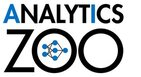
---

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


**Install Analytics Zoo**

You can install the latest release version or latest pre-release version using `pip install --pre --upgrade analytics-zoo`. 

In [ ]:
# Install latest release version of analytics-zoo 
# Installing analytics-zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade analytics-zoo[ray]

## **Using Spark Dataframes for Distribtued Deep Learning** 

In this guide we will describe how to use Spark Dataframes to process large-scale dataset.

#### **Intialization** 

import necessary libraries

In [ ]:
import os
import zipfile
import argparse

import numpy as np

from bigdl.dataset import base
from sklearn.model_selection import train_test_split

from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca import OrcaContext
from zoo.orca.learn.tf2 import Estimator
from zoo.orca.data import SharedValue
from pyspark.sql.functions import col
import zoo.orca.data.pandas

## **Init Orca Context** 

In [ ]:
# recommended to set it to True when running Analytics Zoo in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":  
    init_orca_context(cluster_mode="local", cores=1) # run in local mode
elif cluster_mode == "yarn":  
    init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2, driver_memory="6g") # run on Hadoop YARN cluster

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.13.1-SNAPSHOT-spark_2.4.6-0.12.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/lib/bigdl-0.13.1-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
2022-02-26 00:28:58 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


cls.getname: com.intel.analytics.bigdl.python.api.Sample
BigDLBasePickler registering: bigdl.util.common  Sample
cls.getname: com.intel.analytics.bigdl.python.api.EvaluatedResult
BigDLBasePickler registering: bigdl.util.common  EvaluatedResult
cls.getname: com.intel.analytics.bigdl.python.api.JTensor
BigDLBasePickler registering: bigdl.util.common  JTensor
cls.getname: com.intel.analytics.bigdl.python.api.JActivity
BigDLBasePickler registering: bigdl.util.common  JActivity
Successfully got a SparkContext



User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
  

## **Data Preprocessing with Spark Dataframes**

Orca supports Spark Dataframes as the input to the distributed training, and as the input/output of the distributed inference. Consequently, the user can easily process large-scale dataset using Apache Spark, and directly apply AI models on the distributed (and possibly in-memory) Dataframes without data conversion or serialization.

In [ ]:
# Download and extract movielens 1M data.
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
local_file = base.maybe_download('ml-1m.zip', '.', url)
if not os.path.exists('./ml-1m'):
        zip_ref = zipfile.ZipFile(local_file, 'r')
        zip_ref.extractall('.')
        zip_ref.close()

In [ ]:
# Read in the dataset, and do a little preprocessing
rating_files="./ml-1m/ratings.dat"
new_rating_files="./ml-1m/ratings_new.dat"
if not os.path.exists(new_rating_files):
        fin = open(rating_files, "rt")
        fout = open(new_rating_files, "wt")
        for line in fin:
            # replace :: to : for spark 2.4 support
            fout.write(line.replace('::', ':'))
        fin.close()
        fout.close()

In [ ]:
# read csv
spark = OrcaContext.get_spark_session()
df = spark.read.csv(new_rating_files, sep=':', header=True, inferSchema=True).toDF(
  "user", "item", "label", "timestamp")

user_set = df.select('user').collect()
item_set = df.select('item').collect()

min_user_id = min(user_set)[0]
max_user_id = max(user_set)[0]
min_item_id = min(item_set)[0]
max_item_id = max(item_set)[0]
print(min_user_id, max_user_id, min_item_id, max_item_id)

1 6040 1 3952


In [ ]:
# update label starting from 0
df = df.withColumn('label', df.label-1)

In [ ]:
# split to train/test dataset
train_data, test_data = df.randomSplit([0.8, 0.2], 100)

### **Define NCF Model**

In [ ]:
def model_creator(config):
    import tensorflow as tf
    from tensorflow import keras
    embedding_size=16
    user = keras.layers.Input(dtype=tf.int32, shape=(None,))
    item = keras.layers.Input(dtype=tf.int32, shape=(None,))
    label = keras.layers.Input(dtype=tf.int32, shape=(None,))

    with tf.name_scope("GMF"):
        user_embed_GMF = keras.layers.Embedding(max_user_id + 1, embedding_size)(user)
        item_embed_GMF = keras.layers.Embedding(max_item_id + 1, embedding_size)(item)
        GMF = keras.layers.Multiply()([user_embed_GMF, item_embed_GMF])

    with tf.name_scope("MLP"):
        user_embed_MLP = keras.layers.Embedding(max_user_id + 1, embedding_size)(user)
        item_embed_MLP = keras.layers.Embedding(max_item_id + 1, embedding_size)(item)
        interaction = tf.concat([user_embed_MLP, item_embed_MLP], axis=-1)
        layer1_MLP = keras.layers.Dense(units=embedding_size * 2, activation='relu')(interaction)
        layer1_MLP = keras.layers.Dropout(rate=0.2)(layer1_MLP)
        layer2_MLP = keras.layers.Dense(units=embedding_size, activation='relu')(layer1_MLP)
        layer2_MLP = keras.layers.Dropout(rate=0.2)(layer2_MLP)
        layer3_MLP = keras.layers.Dense(units=embedding_size // 2, activation='relu')(layer2_MLP)
        layer3_MLP = keras.layers.Dropout(rate=0.2)(layer3_MLP)

    # Concate the two parts together
    with tf.name_scope("concatenation"):
        concatenation = tf.concat([GMF, layer3_MLP], axis=-1)
        outputs = keras.layers.Dense(units=5, activation='softmax')(concatenation)
    
    model = keras.Model(inputs=[user, item], outputs=outputs)
    model.compile(optimizer= "adam",
                  loss= "sparse_categorical_crossentropy",
                  metrics=['accuracy'])
    return model

### **Fit with Orca Estimator**

In [ ]:
batch_size= 640 #1280
# epochs: 1280
#   2 : 78/78 [==============================] - 0s 2ms/step - loss: 1.2407 - accuracy: 0.4427 
#   20: 625/625 [==============================] - 8s 12ms/step - loss: 1.0160 - accuracy: 0.5663 - val_loss: 1.3147 - val_accuracy: 0.4401
#   40: 625/625 [==============================] - 8s 12ms/step - loss: 0.9694 - accuracy: 0.5794 - val_loss: 1.4312 - val_accuracy: 0.4436
# bs: 640
#   40: 1250/1250 [==============================] - 11s 9ms/step - loss: 0.9659 - accuracy: 0.5821 - val_loss: 1.4135 - val_accuracy: 0.4460

epochs=40
model_dir='./'

# create an Estimator
est = Estimator.from_keras(model_creator=model_creator, workers_per_node=1)

stats = est.fit(train_data,
                epochs=epochs,
                batch_size=batch_size,
                feature_cols=['user', 'item'],
                label_cols=['label'],
                steps_per_epoch=800000 // batch_size,
                validation_data=test_data,
                validation_steps = 200000 // batch_size)

checkpoint_path = os.path.join(model_dir, "NCF.ckpt")
est.save(checkpoint_path)

(pid=3905) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/zoo/orca/learn/tf2/tf_runner.py:317: _CollectiveAllReduceStrategyExperimental.__init__ (from tensorflow.python.distribute.collective_all_reduce_strategy) is deprecated and will be removed in a future version.
(pid=3905) Instructions for updating:
(pid=3905) use distribute.MultiWorkerMirroredStrategy instead
(pid=3905) 2022-02-26 00:56:49.948740: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-26 00:57:16,122	INFO worker.py:655 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
(pid=3905) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/zoo/orca/learn/tf2/tf_runner.py:195: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
(pid=3905) Instructions for updating:
(pid=3905) rename to

(pid=3905) Epoch 1/40


(pid=3905) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (None,).
(pid=3905) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_2'), name='input_2', description="created by layer 'input_2'"), but it was called on an input with incompatible shape (None,).


1245/1250 [============================>.] - ETA: 0s - loss: 1.3601 - accuracy: 0.3774


(pid=3905) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (None,).
(pid=3905) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_2'), name='input_2', description="created by layer 'input_2'"), but it was called on an input with incompatible shape (None,).


1250/1250 [==============================] - 13s 8ms/step - loss: 1.3599 - accuracy: 0.3775 - val_loss: 1.2710 - val_accuracy: 0.4315
(pid=3905) Epoch 2/40
1250/1250 [==============================] - 10s 8ms/step - loss: 1.2555 - accuracy: 0.4370 - val_loss: 1.2185 - val_accuracy: 0.4557
(pid=3905) Epoch 3/40
1243/1250 [============================>.] - ETA: 0s - loss: 1.1914 - accuracy: 0.4796


(pid=3905) 2022-02-26 00:57:48.110723: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 10s 8ms/step - loss: 1.1913 - accuracy: 0.4796 - val_loss: 1.2138 - val_accuracy: 0.4544
(pid=3905) Epoch 4/40
1250/1250 [==============================] - 10s 8ms/step - loss: 1.1477 - accuracy: 0.5047 - val_loss: 1.2250 - val_accuracy: 0.4493
(pid=3905) Epoch 5/40
1250/1250 [==============================] - 10s 8ms/step - loss: 1.1196 - accuracy: 0.5186 - val_loss: 1.2362 - val_accuracy: 0.4464
(pid=3905) Epoch 6/40
1248/1250 [============================>.] - ETA: 0s - loss: 1.1004 - accuracy: 0.5277


(pid=3905) 2022-02-26 00:58:18.900370: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 11s 9ms/step - loss: 1.1004 - accuracy: 0.5277 - val_loss: 1.2450 - val_accuracy: 0.4453
(pid=3905) Epoch 7/40
1250/1250 [==============================] - 11s 9ms/step - loss: 1.0866 - accuracy: 0.5336 - val_loss: 1.2519 - val_accuracy: 0.4447
(pid=3905) Epoch 8/40
1250/1250 [==============================] - 10s 8ms/step - loss: 1.0746 - accuracy: 0.5387 - val_loss: 1.2586 - val_accuracy: 0.4437
(pid=3905) Epoch 9/40
1247/1250 [============================>.] - ETA: 0s - loss: 1.0653 - accuracy: 0.5426


(pid=3905) 2022-02-26 00:58:51.091367: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 10s 8ms/step - loss: 1.0653 - accuracy: 0.5426 - val_loss: 1.2641 - val_accuracy: 0.4434
(pid=3905) Epoch 10/40
1250/1250 [==============================] - 12s 9ms/step - loss: 1.0565 - accuracy: 0.5467 - val_loss: 1.2699 - val_accuracy: 0.4426
(pid=3905) Epoch 11/40
1250/1250 [==============================] - 12s 9ms/step - loss: 1.0489 - accuracy: 0.5497 - val_loss: 1.2748 - val_accuracy: 0.4423
(pid=3905) Epoch 12/40
1250/1250 [==============================] - ETA: 0s - loss: 1.0420 - accuracy: 0.5524


(pid=3905) 2022-02-26 00:59:25.123122: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 10s 8ms/step - loss: 1.0420 - accuracy: 0.5524 - val_loss: 1.2801 - val_accuracy: 0.4431
(pid=3905) Epoch 13/40
1250/1250 [==============================] - 10s 8ms/step - loss: 1.0362 - accuracy: 0.5544 - val_loss: 1.2859 - val_accuracy: 0.4433
(pid=3905) Epoch 14/40
1250/1250 [==============================] - 10s 8ms/step - loss: 1.0306 - accuracy: 0.5565 - val_loss: 1.2912 - val_accuracy: 0.4433
(pid=3905) Epoch 15/40
1247/1250 [============================>.] - ETA: 0s - loss: 1.0256 - accuracy: 0.5588


(pid=3905) 2022-02-26 00:59:55.628624: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 10s 8ms/step - loss: 1.0256 - accuracy: 0.5588 - val_loss: 1.2950 - val_accuracy: 0.4435
(pid=3905) Epoch 16/40
1250/1250 [==============================] - 10s 8ms/step - loss: 1.0216 - accuracy: 0.5606 - val_loss: 1.3006 - val_accuracy: 0.4431
(pid=3905) Epoch 17/40
1250/1250 [==============================] - 10s 8ms/step - loss: 1.0172 - accuracy: 0.5622 - val_loss: 1.3069 - val_accuracy: 0.4440
(pid=3905) Epoch 18/40
1244/1250 [============================>.] - ETA: 0s - loss: 1.0134 - accuracy: 0.5637


(pid=3905) 2022-02-26 01:00:26.368548: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 11s 8ms/step - loss: 1.0134 - accuracy: 0.5636 - val_loss: 1.3127 - val_accuracy: 0.4441
(pid=3905) Epoch 19/40
1250/1250 [==============================] - 11s 8ms/step - loss: 1.0093 - accuracy: 0.5655 - val_loss: 1.3171 - val_accuracy: 0.4441
(pid=3905) Epoch 20/40
1250/1250 [==============================] - 12s 9ms/step - loss: 1.0062 - accuracy: 0.5663 - val_loss: 1.3227 - val_accuracy: 0.4437
(pid=3905) Epoch 21/40
1249/1250 [============================>.] - ETA: 0s - loss: 1.0032 - accuracy: 0.5679


(pid=3905) 2022-02-26 01:00:59.319508: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 11s 9ms/step - loss: 1.0032 - accuracy: 0.5679 - val_loss: 1.3274 - val_accuracy: 0.4442
(pid=3905) Epoch 22/40
1250/1250 [==============================] - 11s 9ms/step - loss: 1.0001 - accuracy: 0.5688 - val_loss: 1.3320 - val_accuracy: 0.4438
(pid=3905) Epoch 23/40
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9973 - accuracy: 0.5705 - val_loss: 1.3347 - val_accuracy: 0.4450
(pid=3905) Epoch 24/40
1249/1250 [============================>.] - ETA: 0s - loss: 0.9943 - accuracy: 0.5712


(pid=3905) 2022-02-26 01:01:31.549292: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 12s 10ms/step - loss: 0.9943 - accuracy: 0.5712 - val_loss: 1.3427 - val_accuracy: 0.4445
(pid=3905) Epoch 25/40
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9919 - accuracy: 0.5723 - val_loss: 1.3461 - val_accuracy: 0.4454
(pid=3905) Epoch 26/40
1250/1250 [==============================] - 11s 8ms/step - loss: 0.9899 - accuracy: 0.5728 - val_loss: 1.3498 - val_accuracy: 0.4452
(pid=3905) Epoch 27/40
1247/1250 [============================>.] - ETA: 0s - loss: 0.9872 - accuracy: 0.5742


(pid=3905) 2022-02-26 01:02:04.847212: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 11s 9ms/step - loss: 0.9873 - accuracy: 0.5742 - val_loss: 1.3545 - val_accuracy: 0.4445
(pid=3905) Epoch 28/40
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9852 - accuracy: 0.5746 - val_loss: 1.3606 - val_accuracy: 0.4450
(pid=3905) Epoch 29/40
1250/1250 [==============================] - 10s 8ms/step - loss: 0.9827 - accuracy: 0.5757 - val_loss: 1.3637 - val_accuracy: 0.4444
(pid=3905) Epoch 30/40
1249/1250 [============================>.] - ETA: 0s - loss: 0.9812 - accuracy: 0.5762


(pid=3905) 2022-02-26 01:02:36.790876: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 11s 9ms/step - loss: 0.9812 - accuracy: 0.5762 - val_loss: 1.3671 - val_accuracy: 0.4451
(pid=3905) Epoch 31/40
1250/1250 [==============================] - 11s 8ms/step - loss: 0.9790 - accuracy: 0.5771 - val_loss: 1.3752 - val_accuracy: 0.4462
(pid=3905) Epoch 32/40
1250/1250 [==============================] - 12s 10ms/step - loss: 0.9772 - accuracy: 0.5785 - val_loss: 1.3785 - val_accuracy: 0.4457
(pid=3905) Epoch 33/40
1248/1250 [============================>.] - ETA: 0s - loss: 0.9757 - accuracy: 0.5780


(pid=3905) 2022-02-26 01:03:11.743010: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 12s 9ms/step - loss: 0.9758 - accuracy: 0.5780 - val_loss: 1.3827 - val_accuracy: 0.4464
(pid=3905) Epoch 34/40
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9743 - accuracy: 0.5788 - val_loss: 1.3838 - val_accuracy: 0.4464
(pid=3905) Epoch 35/40
1250/1250 [==============================] - 12s 10ms/step - loss: 0.9724 - accuracy: 0.5792 - val_loss: 1.3910 - val_accuracy: 0.4461
(pid=3905) Epoch 36/40
1250/1250 [==============================] - ETA: 0s - loss: 0.9711 - accuracy: 0.5802


(pid=3905) 2022-02-26 01:03:46.267407: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 11s 9ms/step - loss: 0.9711 - accuracy: 0.5802 - val_loss: 1.3963 - val_accuracy: 0.4474
(pid=3905) Epoch 37/40
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9698 - accuracy: 0.5807 - val_loss: 1.4017 - val_accuracy: 0.4469
(pid=3905) Epoch 38/40
1250/1250 [==============================] - 11s 8ms/step - loss: 0.9683 - accuracy: 0.5812 - val_loss: 1.4044 - val_accuracy: 0.4468
(pid=3905) Epoch 39/40
1248/1250 [============================>.] - ETA: 0s - loss: 0.9671 - accuracy: 0.5819


(pid=3905) 2022-02-26 01:04:18.518584: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 11s 9ms/step - loss: 0.9672 - accuracy: 0.5819 - val_loss: 1.4097 - val_accuracy: 0.4465
(pid=3905) Epoch 40/40
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9659 - accuracy: 0.5821 - val_loss: 1.4135 - val_accuracy: 0.4460


'./NCF.ckpt'

In [ ]:
# evaluate with Estimator
stats = est.evaluate(test_data, 
                     feature_cols=['user', 'item'],
                     label_cols=['label'],
                     num_steps=100000 // batch_size)
est.shutdown()
print(stats)

2022-02-26 01:04:48,101	INFO worker.py:655 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379


141/156 [==========================>...] - ETA: 0s - loss: 1.4568 - accuracy: 0.4384
[{'validation_loss': 1.4421526193618774, 'validation_accuracy': 0.43930289149284363}]


In [ ]:
# stop_orca_context()